<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Libraries And Utilities</h3>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud,STOPWORDS
import spacy as sp
import string
import nltk
import re
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nlps = sp.load('en')
from nltk.util import ngrams
from nltk import word_tokenize
def RMSE(y,yh):
    return np.sqrt(mean_squared_error(y,yh))


plt.rc('figure',figsize=(18,11))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [2]:
d_data =pd.read_csv('/kaggle/input/drake-lyrics/drake_data.csv',usecols=['album','lyrics_title','lyrics','track_views'])
d_data.head(4)

album                           lyrics_title  \
0  Certified Lover Boy            Certified Lover Boy* Lyrics   
1  Certified Lover Boy  Like I’m Supposed To/Do Things Lyrics   
2  Certified Lover Boy                      Not Around Lyrics   
3  Certified Lover Boy    In the Cut (Ft. Roddy Ricch) Lyrics   

                                              lyrics track_views  
0  [Verse]\nPut my feelings on ice\nAlways been a...        8.7K  
1  [Verse]\nHands are tied\nSomeone's in my ear f...       38.8K  
2  [Intro]\nYeah, we back\nWassup ladies?\nSwisha...      129.8K  
3  [Intro: Drake]\nAyy, yeah\nPipe this shit up a...       72.1K

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Data Preprocessing And Feature Engineering</h3>


In [3]:
preprocessed = d_data.copy()
for col in preprocessed.columns[:-1]:
    preprocessed[col] = preprocessed[col].str.lower()

    
preprocessed.lyrics_title     = preprocessed.lyrics_title.apply(lambda x: x.replace('lyrics',''))
preprocessed['is_demo']       = preprocessed.lyrics_title.apply(lambda x: 1 if x.find('(demo)') != -1 else 0)
preprocessed.lyrics_title     = preprocessed.lyrics_title.apply(lambda x: x.replace('(demo)',''))

def extract_feat(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find('ft.') != -1:
        return artist.replace('ft. ','')
    else:
        return 'solo'
    
def remove_artist(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find('ft.') != -1:
        return s[:s.find("(")]
    else:
        return s
preprocessed['featuring'] = preprocessed.lyrics_title.apply(extract_feat)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(remove_artist)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(remove_artist)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x:re.sub(r'[^\w\s]', '', x) )

def view_preprocess(s):
    if type(s)!= float:
        if s[-1]=='K':
            return float(s.replace('K',''))*1000
        if s[-1]=='M':
            return float(s.replace('M',''))*10**6

preprocessed.track_views = preprocessed.track_views.apply(view_preprocess)


preprocessed = preprocessed.loc[preprocessed.lyrics.dropna().index,:]

preprocessed['number_of_verses']=0
preprocessed['number_of_chorus']=0
preprocessed.loc[preprocessed.lyrics.notna().index,'number_of_verses'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r'verse',x)))
preprocessed.loc[preprocessed.lyrics.notna().index,'number_of_chorus'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r'chorus',x)))

preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: re.sub(r'\[([^]]*)]','',x))
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: x.replace('\n',' '))
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:re.sub(r'[^\w\s]', '', x))


sid = SIA()
preprocessed['sentiments']           = preprocessed['lyrics'].apply(lambda x: sid.polarity_scores(x))
preprocessed['Positive Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['pos']) 
preprocessed['Neutral Sentiment']    = preprocessed['sentiments'].apply(lambda x: x['neu'])
preprocessed['Negative Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['neg'])

preprocessed.drop(columns=['sentiments'],inplace=True)

preprocessed['# Of Words']                 = preprocessed['lyrics'].apply(lambda x: len(x.split(' ')))
preprocessed['# Of StopWords']             = preprocessed['lyrics'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
preprocessed['Average Word Length']        = preprocessed['lyrics'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))
preprocessed['Average Sentence Length']    = preprocessed['lyrics'].apply(lambda x: np.mean(np.array([len(va) for va in x.split('.')])))







#Album Mean Statistics DF
album_d = preprocessed.groupby(by='album').mean()
album_d.drop(index='unreleased songs',inplace=True)
album_d['Release_Year'] = 0
album_d.loc['care package','Release_Year']                         =2019
album_d.loc['certified lover boy','Release_Year']                  =2021
album_d.loc['comeback season','Release_Year']                      =2007
album_d.loc['dark lane demo tapes','Release_Year']                 =2020
album_d.loc['drake demo disk','Release_Year']                      =2006
album_d.loc['if you’re reading this it’s too late','Release_Year'] =2015
album_d.loc['more life','Release_Year']                            =2017
album_d.loc['nothing was the same','Release_Year']                 =2013
album_d.loc['room for improvement','Release_Year']                 =2006
album_d.loc['scary hours','Release_Year']                          =2018
album_d.loc['scorpion','Release_Year']                             =2018
album_d.loc['so far gone','Release_Year']                          =2009
album_d.loc['so far gone (ep)','Release_Year']                     =2009
album_d.loc['take care','Release_Year']                            =2011
album_d.loc['thank me later','Release_Year']                       =2010
album_d.loc['the best in the world pack','Release_Year']           =2019
album_d.loc['views','Release_Year']                                =2016



preprocessed.head(3)

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   

  featuring  number_of_verses  number_of_chorus  Positive Sentiment  \
0      solo                 1                 0               0.158   
1      solo                 1                 2               0.143   
2      solo                 2                 3               0.069   

   Neutral Sentiment  Negative Sentiment  # Of Words  # Of StopWords  \
0              0.708               0.133          21               6   
1              0.790               0.067         180              96   
2              0.751               0.180         566             286   

   Average Word Length  Average Sentence Length  
0             5.200000                    113.0  
1             4.535714                    825.0  
2             4.857143                   2691.0

<h3 style="background-color:orange;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;">Exploratory Data Analysis</h3>


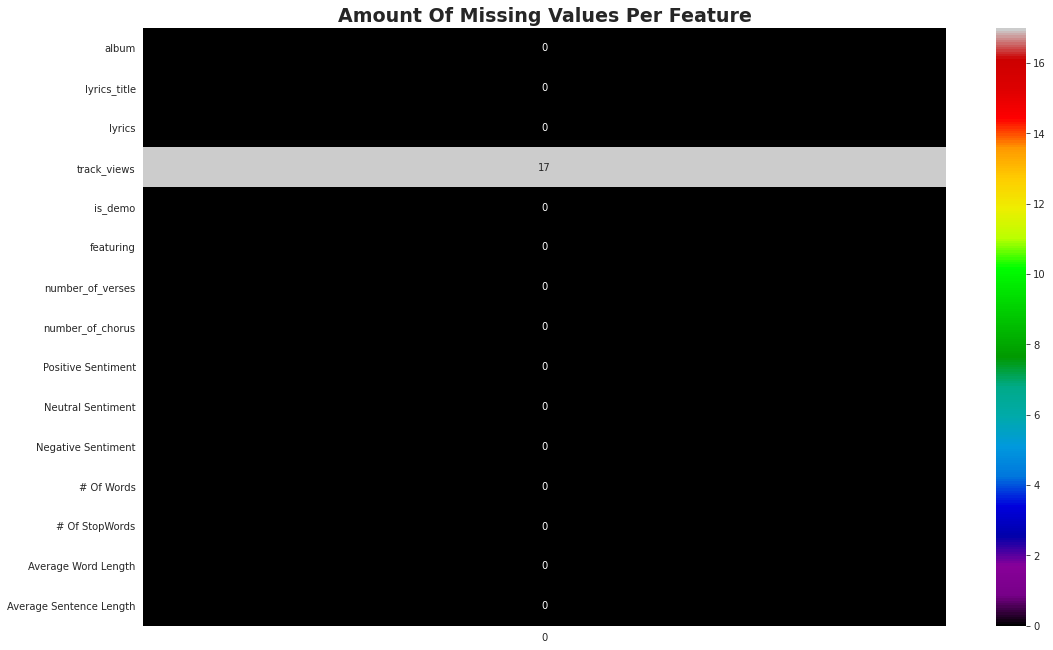

In [4]:
plt.title('Amount Of Missing Values Per Feature',fontsize=19,fontweight='bold')
sns.heatmap(preprocessed.isna().sum().to_frame(),annot=True,cmap='nipy_spectral')
plt.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Label Based Analysis</h3>


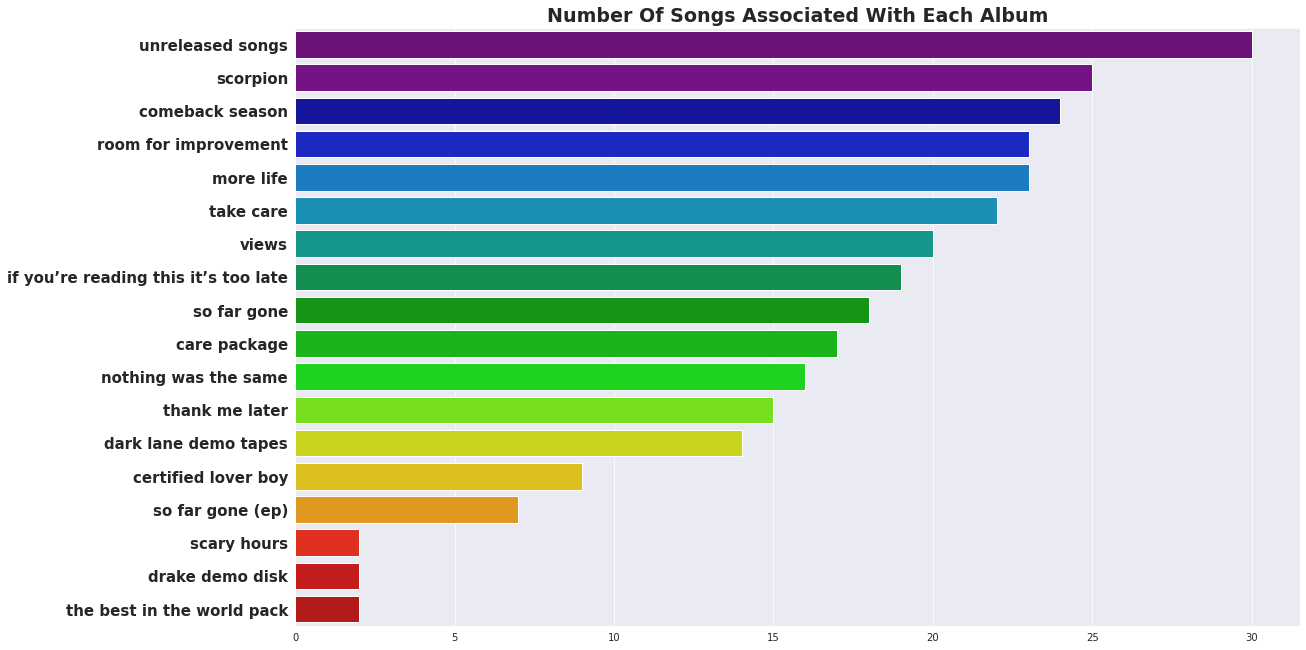

In [5]:
plt.title('Number Of Songs Associated With Each Album',fontsize=19,fontweight='bold')
ax = sns.barplot(y=preprocessed.album.value_counts().index,x=preprocessed.album.value_counts().values,palette='nipy_spectral')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15,fontweight='bold')
plt.show()

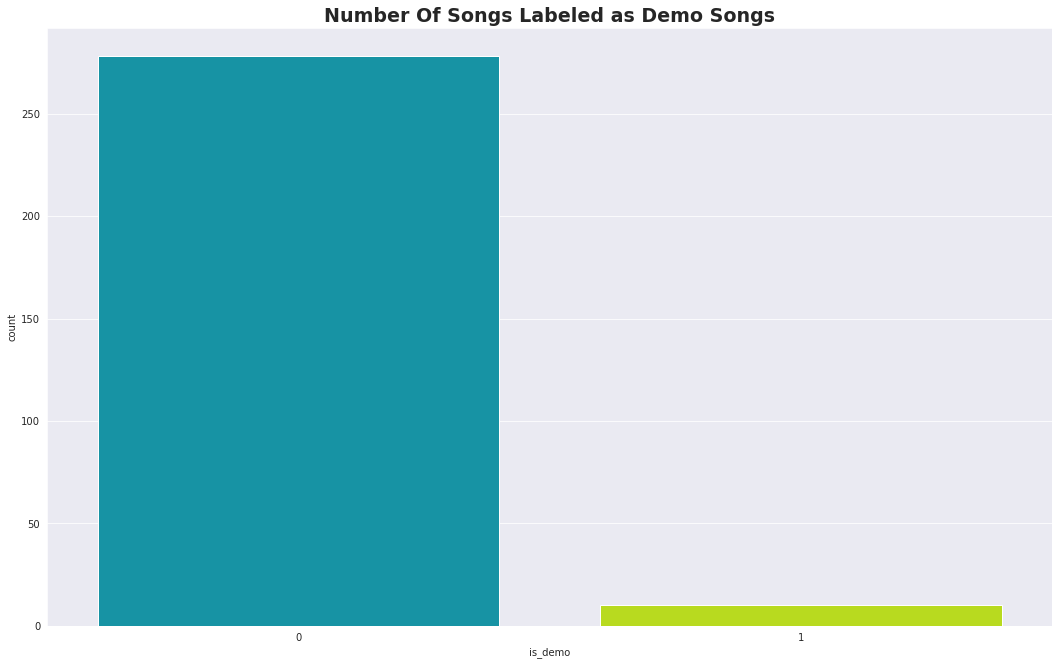

In [6]:
plt.title('Number Of Songs Labeled as Demo Songs',fontsize=19,fontweight='bold')
ax = sns.countplot(preprocessed.is_demo,palette='nipy_spectral')
plt.show()

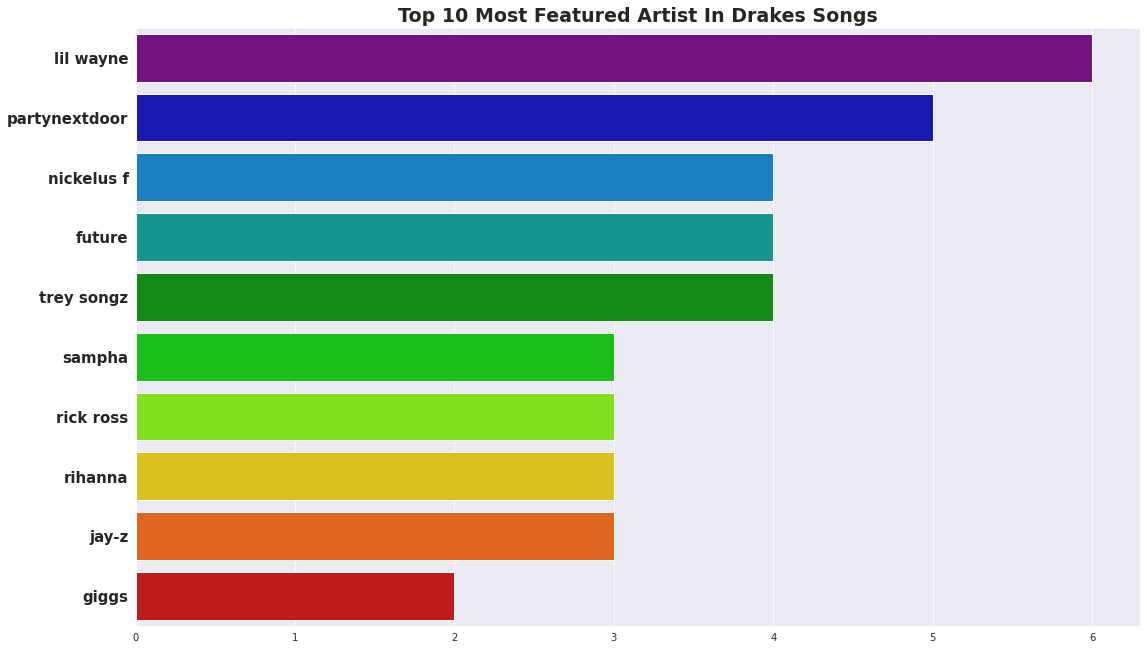

In [7]:
plt.title('Top 10 Most Featured Artist In Drakes Songs',fontsize=19,fontweight='bold')
ax = sns.barplot(y=preprocessed.featuring.value_counts()[1:11].index,x=preprocessed.featuring.value_counts()[1:11].values,palette='nipy_spectral')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15,fontweight='bold')
plt.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Numeric Feature Analysis</h3>


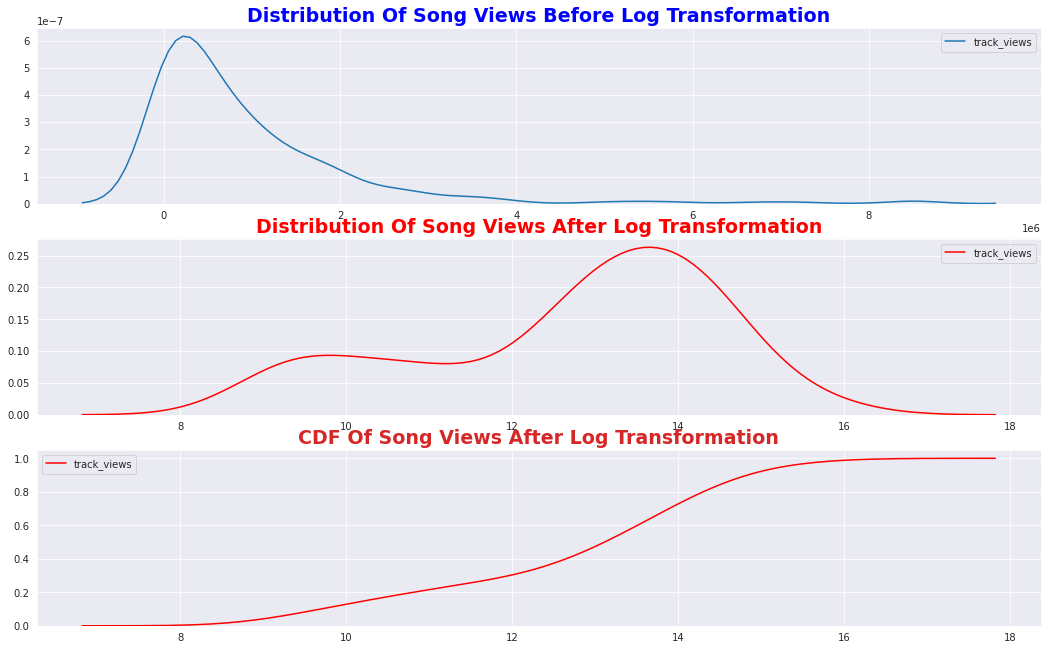

In [8]:
plt.subplot(3,1,1)
plt.title('Distribution Of Song Views Before Log Transformation',fontsize=19,fontweight='bold',color='b')
sns.kdeplot(preprocessed.track_views)
plt.subplot(3,1,2)
preprocessed.track_views= np.log(preprocessed.track_views)
plt.title('Distribution Of Song Views After Log Transformation',fontsize=19,fontweight='bold',color='r')
sns.kdeplot(preprocessed.track_views,color='r')
plt.subplot(3,1,3)
plt.title('CDF Of Song Views After Log Transformation',fontsize=19,fontweight='bold',color='tab:red')
sns.kdeplot(preprocessed.track_views,color='r',cumulative=True)
plt.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We can observe that after performing log transformation on Drake's song views, we get a bimodal distribution,</span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>In other words, in log space, Drake's songs have 2 groups of which one is less dominant, but the presence of 2 underlaying groups is undeniable, and it is fascinating to understand what are those groups!</span></p>

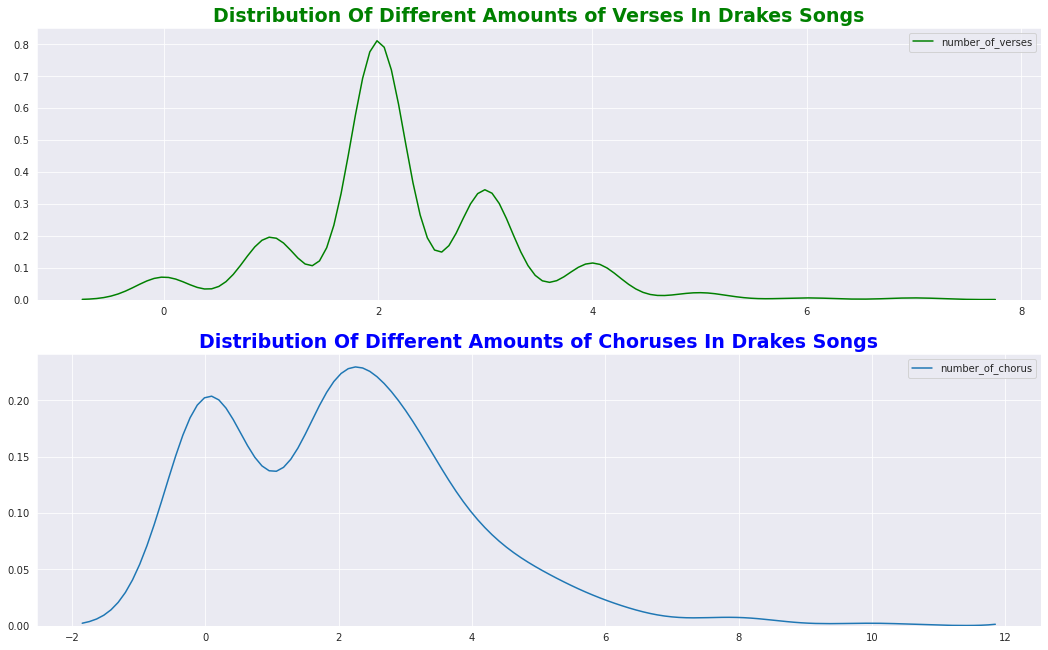

In [9]:
plt.subplot(2,1,1)
plt.title('Distribution Of Different Amounts of Verses In Drakes Songs',fontsize=19,fontweight='bold',color='g')
sns.kdeplot(preprocessed.number_of_verses,color='g')
plt.subplot(2,1,2)
plt.title('Distribution Of Different Amounts of Choruses In Drakes Songs',fontsize=19,fontweight='bold',color='b')
sns.kdeplot(preprocessed.number_of_chorus)

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>So the number of verses and choruses also follow multimodal distributions.</span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;">The number of verses is more versatile and reminds us of a categorical value rather than a numeric one.</span></span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>On the other hand, the number of choruses follows a bimodal distribution, and it is hard not to wonder if there is any connection between the bimodal distribution of the number of views and this distribution.</span></p>

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Correlation Analysis</h3>


In [10]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))



s_val =preprocessed.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1),
    row=1, col=1
)


s_val =preprocessed.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1),
    row=2, col=1
)
fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
fig.update_layout(height=700, width=900, title_text="Correlations Between Our Different Numeric Features")
fig.show()

In [11]:
fig = go.Figure()
album_d = album_d.sort_values(by='Release_Year')
album_dm = album_d.groupby(by='Release_Year').mean().reset_index()

for column in album_dm.columns[:-1]:
    fig.add_trace(
        go.Scatter(
            x = album_dm.Release_Year,
            y = album_dm[column],
            name = column,
        )
    )
    

btns = []
for x,col in enumerate(album_dm.columns[:-1]):
    bol = [False]*12
    bol[x]=True
    d = dict(label = col,
                  method = 'update',
                  args = [{'visible':bol},
                          {'title': 'Distribution of [' +col+'] Over The Years',
                           'showlegend':True}])
    btns.append(d)
    
    
fig.update_layout(title='Feautres Distribution Over The Years',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        showactive=True,
        buttons=btns
        )
    ])

fig.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">Album Based Analysis</h3>


In [12]:
album_mean = album_d.sort_values(by='Release_Year')

album_year_index =[album + "  "+ str(year) for album,year in zip(album_mean.index,album_mean.Release_Year)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Positive Sentiment'],
                    mode='lines+markers',
                    name='Mean Positive Sentiment Value',hovertext=album_mean['Release_Year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['Negative Sentiment'],
                    mode='lines+markers',
                    name='Mean Negative Sentiment Value',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Album Sentiment Change Over The Years')
fig.show()
#album_mean

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['number_of_verses'],
                    mode='lines+markers',
                    name='Mean Verse Amount',hovertext=album_mean['Release_Year']))
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['number_of_chorus'],
                    mode='lines+markers',
                    name='Mean Chorus Amount',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Album Chorus and Verse Count Change Over The Years')
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>An interesting observation appears when we look into each album&apos;s mean values; when looking at the average value of choruses and verses in each album, we can see that in Drake&apos;s earlier years, the ratio between verses and choruses was opposite. Still, all the albums released between 2010 and 2017 share almost an identical ratio; what&apos;s even more fascinating is that it is clear that after 2017 Drake&apos;s albums resemble the ones in his early career stages.</span></p>
<p><br></p>

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=album_year_index, y=album_mean['track_views'],
                    mode='lines+markers',
                    name='Mean Verse Amount',hovertext=album_mean['Release_Year']))

fig.update_layout(title='Album Views Over The Years')
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>&quot;Scary Hours&quot; and &quot;Nothing was the Same&quot; definitely were of major significance to Drake&apos;s total success as they had the highest average views per song.</span></p>
<p><br></p>
<a href="https://ibb.co/g4Z4RJK"><img src="https://i.ibb.co/z6V64Zv/Screenshot-2021-01-09-154638.png" alt="Screenshot-2021-01-09-154638" border="0"></a>
<a href="https://ibb.co/fM4z0Rk"><img src="https://i.ibb.co/6Yg7shH/Screenshot-2021-01-09-173513.png" alt="Screenshot-2021-01-09-173513" border="0"></a>

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Text Based Analysis</h3>


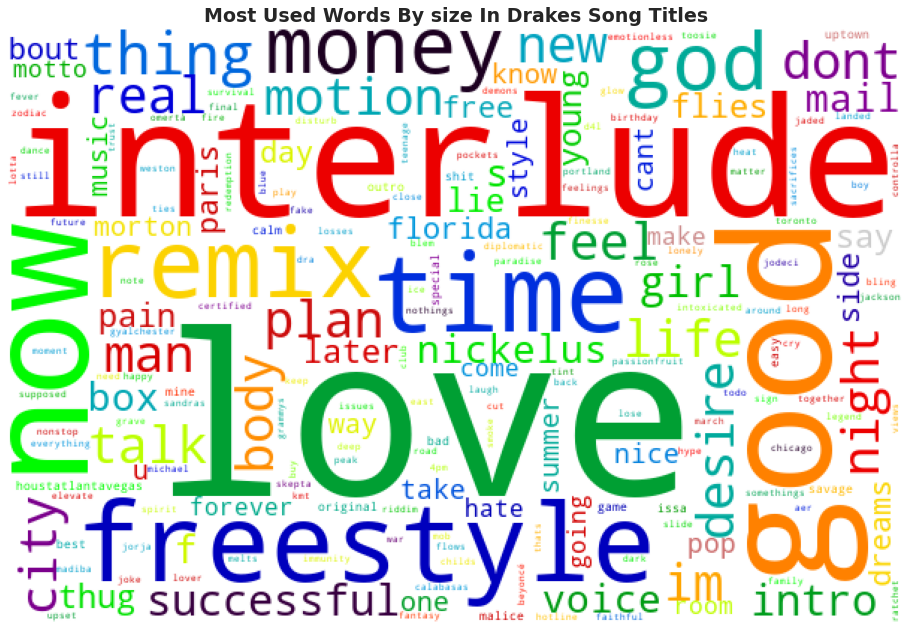

In [15]:
l_t = ' '.join(preprocessed.lyrics_title).strip().replace('drake','')
l_t = l_t.replace('ft','')
w_c = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS,colormap='nipy_spectral',background_color='white').generate(l_t)

plt.title('Most Used Words By size In Drakes Song Titles',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

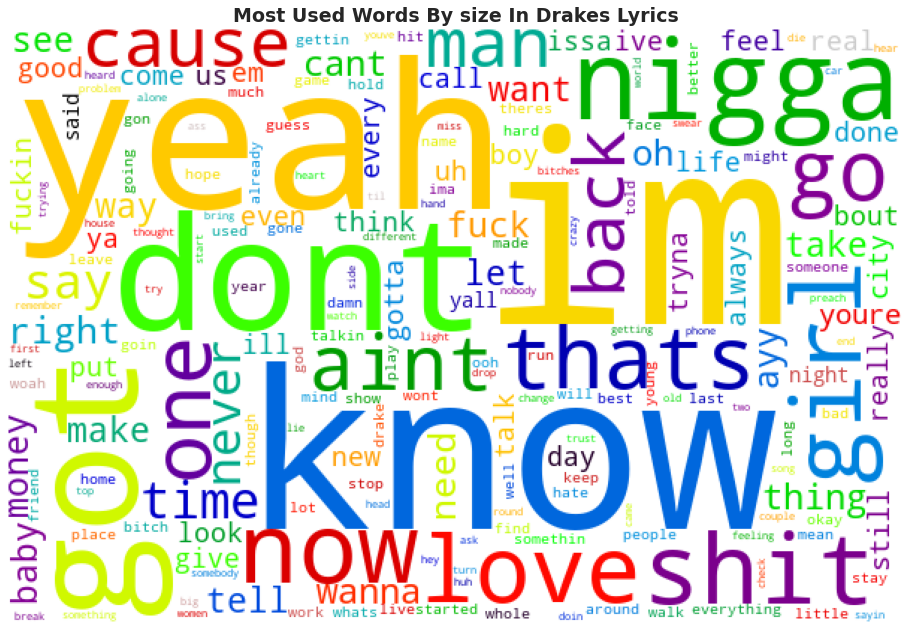

In [16]:
l_t = ' '.join(preprocessed.lyrics[preprocessed.lyrics.notna()]).strip()
w_c = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS,colormap='nipy_spectral',background_color='white').generate(l_t)

plt.title('Most Used Words By size In Drakes Lyrics',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

In [17]:
#preprocessed.lyrics
w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

w2_dict = dict()

top_10_w1 = list(w1_dict.keys())[:10]
token=nltk.word_tokenize(l_t)
trigram =ngrams(token,3)
trigram = [k for k in trigram if k[0] in top_10_w1]

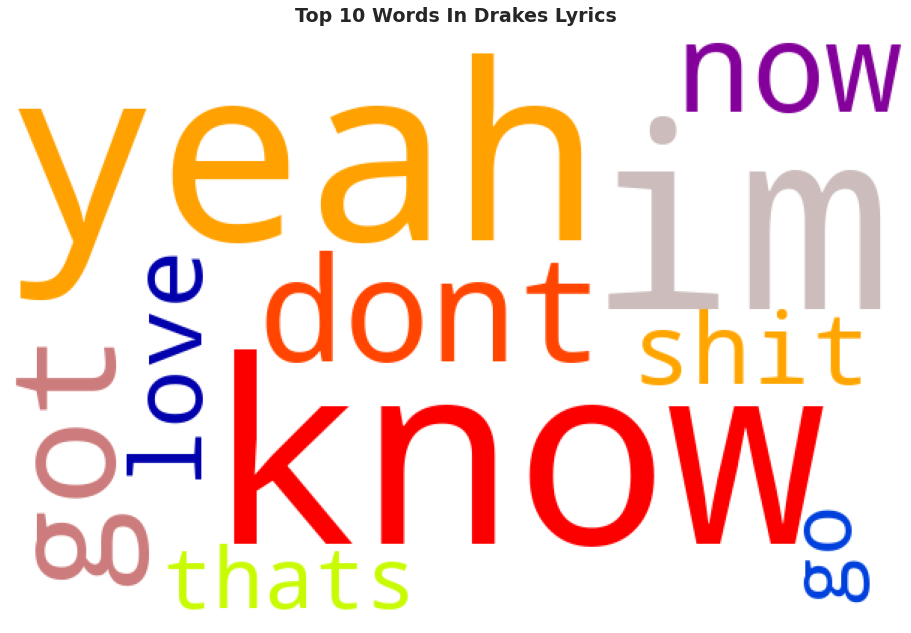

In [18]:
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_w1))
plt.title('Top 10 Words In Drakes Lyrics',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

In [19]:
token=nltk.word_tokenize(l_t)
bigram=ngrams(token,2)
bigram_dict = dict()
for i in bigram:
    bigram_dict[i] = bigram_dict.get(i,0)+1
    
trigram_dict = dict()
for i in trigram:
    trigram_dict[i] = trigram_dict.get(i,0)+1

In [20]:
tri_gram =pd.DataFrame(list(trigram_dict.keys())[:15],columns=['One Of Top 10 Words','Second Word','Third Word'])

def get_prob(sir):
    key = (sir['One Of Top 10 Words'],sir['Second Word'],sir['Third Word'])
    w3 = trigram_dict[key]
    w2 = bigram_dict[(sir['One Of Top 10 Words'],sir['Second Word'])]
    return w3/w2

tri_gram['Probabilty Of Sentence'] = tri_gram.apply(get_prob,axis=1)

tri_gram.style.background_gradient(cmap='coolwarm')

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Above is a trigram of 15 sentences that start with one of the top 10 words and the probability that the sentence will appear in Drake's lyrics.</span></p>
<p><br></p>

<h3 style="background-color:orange;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;">Vectorization And Decomposition </h3>


In [21]:
NUMBER_OF_COMPONENTS=100

CV = CountVectorizer()
svd = TruncatedSVD(NUMBER_OF_COMPONENTS)

c_matrix = CV.fit_transform(preprocessed.lyrics)

dec_matrix = svd.fit_transform(c_matrix)
dec_df=pd.DataFrame(dec_matrix,columns=['PC_{}'.format(i) for i in range(1,NUMBER_OF_COMPONENTS+1)])

ex_var = svd.explained_variance_ratio_
variance_cum = np.cumsum(ex_var)
data = [go.Scatter(x=np.arange(0,len(variance_cum)),y=variance_cum,name='Cumulative Explained Variance',mode='lines+markers'),
        go.Scatter(x=np.arange(0,len(variance_cum)),y=ex_var,name='Explained Variance',mode='lines+markers')]
layout = dict(title='Explained Variance Ratio Using {} Words'.format(NUMBER_OF_COMPONENTS),
             xaxis_title='# Componenets',yaxis_title='Explained Variance',height=650,width=900)
fig = go.Figure(data=data,layout=layout)
fig.update_layout(template='seaborn')
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Apparently, more than 90% of the variance in Drake's lyrics can be explained using only 100 words. We will use a Dataframe of decomposed count vectors for each word to predict the number of views a song might get.</span></p>

In [22]:
dec_df.head(5)

PC_1       PC_2      PC_3      PC_4      PC_5       PC_6      PC_7  \
0   0.521785  -0.229203 -0.218660  0.409704 -0.107594   0.071091  0.660624   
1  22.000534  17.978073 -2.968096 -2.496969  0.963423   4.708171 -0.744390   
2  43.907710 -14.222603 -3.989767 -5.146986 -0.456484   0.515096 -2.067407   
3  29.095665 -15.082048 -4.301063 -8.957937  3.764895 -11.905056 -1.523205   
4  34.884141   5.540462 -2.486184  0.845414 -0.863458  -0.496207  0.910448   

       PC_8       PC_9     PC_10  ...     PC_91     PC_92     PC_93     PC_94  \
0  0.088655   0.025716 -0.436274  ... -0.144724  0.010362 -0.265715 -0.014651   
1  2.906958   3.609326  1.233808  ... -1.444688 -0.507128 -0.903858 -0.130261   
2 -9.994804 -11.939299  0.771516  ... -0.703159 -2.277657  8.675231  2.460243   
3  0.988249   6.870096 -1.740825  ...  0.797589  0.057768  0.810267 -2.906950   
4 -2.391335  -4.497889 -0.254538  ...  1.455852  0.676830  0.220148 -1.041814   

      PC_95     PC_96     PC_97     PC_98     PC_99    PC_100  
0  0.042508  0.123802  0.123782  0.012061 -0.150600  0.211646  
1 -0.148693  0.617434 -0.350214  0.528847  0.191280 -0.127928  
2  0.920250  3.818943  0.306964 -1.982102 -2.186763 -3.216901  
3  0.680620 -0.361053 -0.342457  0.335294  0.277640  0.196168  
4  0.336484  0.047747  1.271782 -0.849094  0.450477  1.062458  

[5 rows x 100 columns]

<h3 style="background-color:orange;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;">Model Selection And Evaluation</h3>


In [23]:
preprocessed=preprocessed.reset_index()
Y = preprocessed.loc[preprocessed.track_views.notna(),'track_views']
X = dec_df.iloc[Y.index,:]

rf_pipe = Pipeline(steps =[  ("RF",RandomForestRegressor(random_state=42)) ])
LR_pipe = Pipeline(steps =[  ("LR",LinearRegression()) ])
RIDGE_pipe = Pipeline(steps =[ ("R",Ridge()) ])


RF_f1_cross_val_scores = np.sqrt(-1*cross_val_score(rf_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))
LR_f1_cross_val_scores= np.sqrt(-1*cross_val_score(LR_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))
RIDGE_f1_cross_val_scores= np.sqrt(-1*cross_val_score(RIDGE_pipe,X,Y,cv=5,scoring='neg_mean_squared_error'))

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">5 Fold Cross Validation</h3>


In [24]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=True,subplot_titles=('Random Forest Cross Val Scores',
                                                                     'Linear Regression Cross Val Scores',
                                                                    'Ridge Regression Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=np.arange(0,len(RF_f1_cross_val_scores)),y=RF_f1_cross_val_scores,name='Random Forest'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(LR_f1_cross_val_scores)),y=LR_f1_cross_val_scores,name='Linear Regression'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(RIDGE_f1_cross_val_scores)),y=RIDGE_f1_cross_val_scores,name='Ridge Regression'),
    row=3, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text="RMSE")
fig.update_xaxes(title_text="Fold #")

fig.show()

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Random Forest Tuning</h3>


In [25]:
def hyperparameter_estimators(X,Y,h_list):
    r_s = []
    for est in h_list:
        model = Pipeline(steps =[  ("RF",RandomForestRegressor(random_state=42,n_estimators=est)) ])
        model.fit(X,Y)
        pred = model.predict(X)
        r_s.append(r2_score(Y,pred))
    return r_s
        

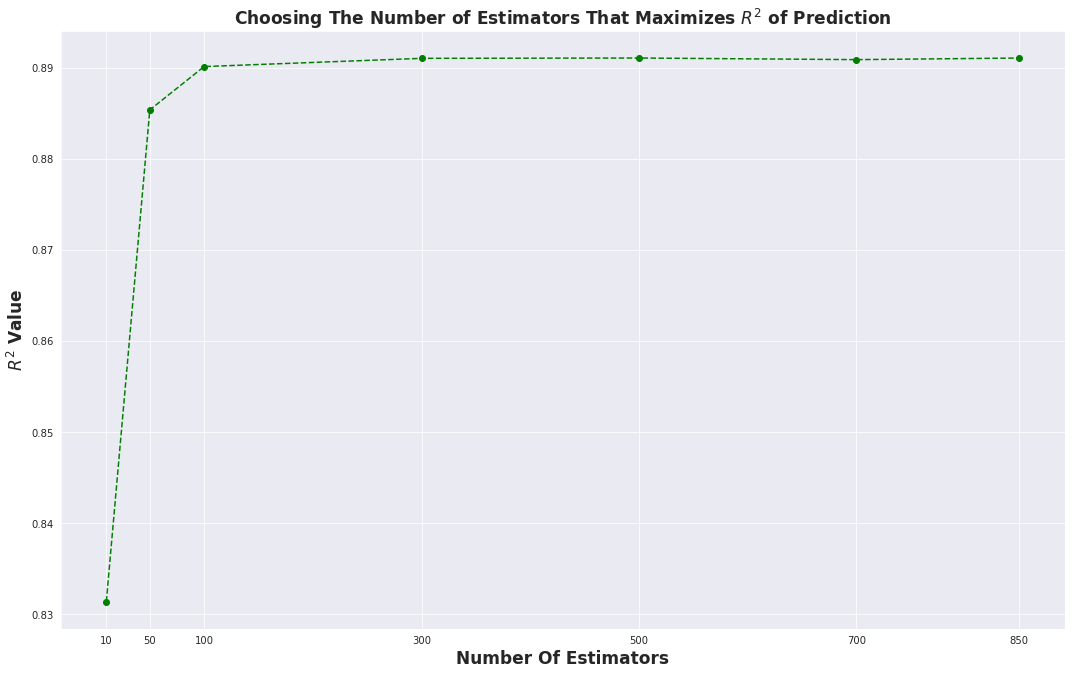

In [26]:
estimators_under_test = [10,50,100,300,500,700,850]
rs = hyperparameter_estimators(X,Y,estimators_under_test)
plt.plot(estimators_under_test,rs,'go--')
plt.title(r'Choosing The Number of Estimators That Maximizes $R^2$ of Prediction',fontsize=17,fontweight='bold')
plt.xticks(estimators_under_test)
plt.ylabel(r'$R^2$ Value',fontsize=17,fontweight='bold')
plt.xlabel(r'Number Of Estimators',fontsize=17,fontweight='bold')
plt.show()

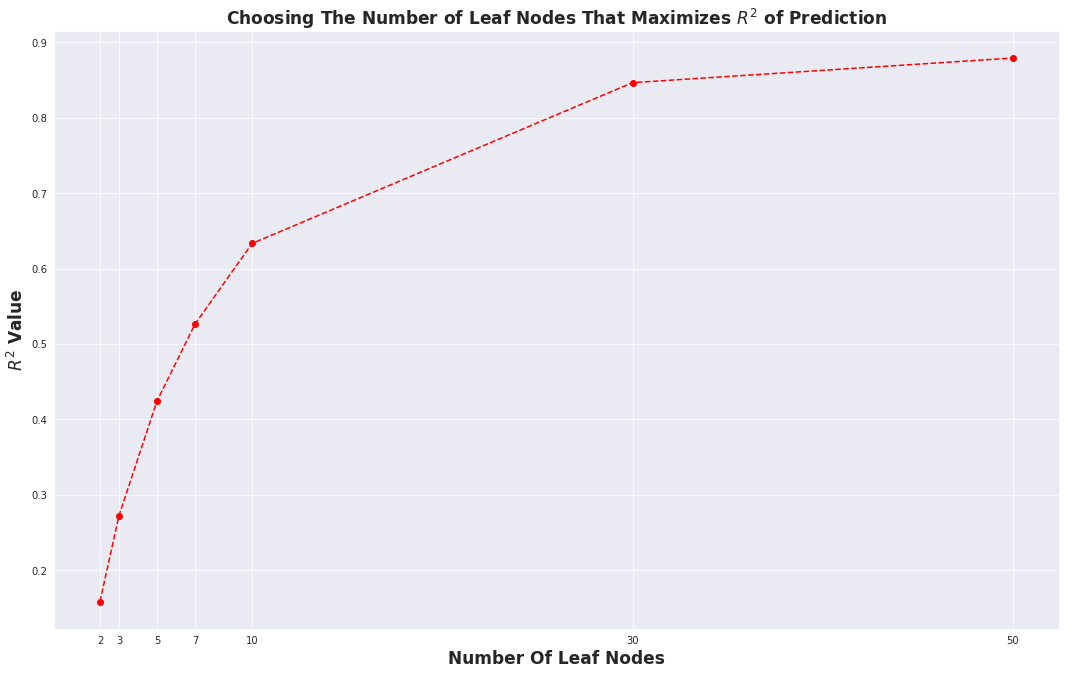

In [27]:
def hyperparameter_estimators(X,Y,h_list):
    r_s = []
    for est in h_list:
        model = Pipeline(steps =[  ("RF",RandomForestRegressor(random_state=42,n_estimators=500,max_leaf_nodes=est)) ])
        model.fit(X,Y)
        pred = model.predict(X)
        r_s.append(r2_score(Y,pred))
    return r_s

nodes_under_test = [2,3,5,7,10,30,50]
rs = hyperparameter_estimators(X,Y,nodes_under_test)
plt.plot(nodes_under_test,rs,'ro--')
plt.title(r'Choosing The Number of Leaf Nodes That Maximizes $R^2$ of Prediction',fontsize=17,fontweight='bold')
plt.xticks(nodes_under_test)
plt.ylabel(r'$R^2$ Value',fontsize=17,fontweight='bold')
plt.xlabel(r'Number Of Leaf Nodes',fontsize=17,fontweight='bold')
plt.show()

In [28]:
rf_pipe = Pipeline(steps =[  ("RF",RandomForestRegressor(random_state=42,n_estimators=500,max_leaf_nodes=50)) ])
rf_pipe.fit(X,Y)
predictions = rf_pipe.predict(X)

<h3 style="background-color:orange;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Total Error And Heteroscedasticity Evaluation</h3>


In [29]:
print('Total RMSE For Prediction On Entire Dataset : {}'.format(RMSE(Y,predictions)))

Total RMSE For Prediction On Entire Dataset : 0.6249748562593835


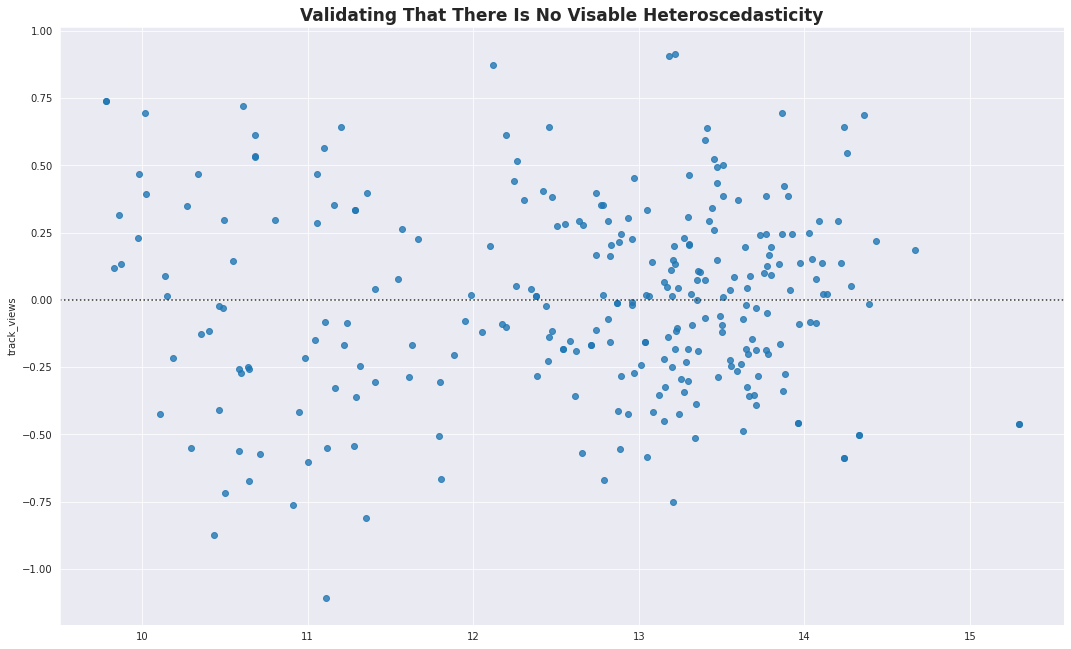

In [30]:
plt.title(r'Validating That There Is No Visable Heteroscedasticity',fontsize=17,fontweight='bold')
sns.residplot(predictions,Y)
plt.show()

In [31]:
output = pd.DataFrame({'Prediction':predictions,'Actual':Y})
output.to_csv('view_prediction.csv',index=False)


In [32]:
fig = make_subplots(
    rows=3, cols=2,subplot_titles=('','Actual','Predictions','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "table","rowspan": 3}     ,{"type": "scatter"}] ,
           [None                               ,{"type": "scatter"}]            ,           
           [None                               ,{"type": "scatter"}]                           
          ]
)

fig.add_trace(
    go.Scatter(
        x=np.arange(0,len(output["Actual"])),
        y=output["Actual"],
        mode="markers",
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=np.arange(0,len(output["Prediction"])),
        y=output["Prediction"],
        mode="markers",
    ),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(
        x=np.arange(0,len(output["Prediction"])),
        y=output["Prediction"]-output["Actual"],
        mode="markers",
    ),
    row=3, col=2
)

fig.add_trace(
    go.Table(
        header=dict(
            values=['Prediction','Actual'],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[output[k].tolist() for k in output.columns],
            align = "left")
    ),
    row=1, col=1
)



fig.add_shape(type="line",
    x0=0, y0=(output["Prediction"]-output["Actual"]).mean(), x1=len(output["Prediction"]), y1=(output["Prediction"]-output["Actual"]).mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x3', 
        yref='y3'
)

fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Prediction Evaluation",
)

fig.show()